<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220907.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analysis
* iterator

In [1]:
import pandas as pd 
import numpy as np 
import plotnine as gg
from plotnine import ggplot, aes

from datetime import datetime, date, time, timezone, timedelta 
import os
import re

from functools import reduce
from collections import defaultdict, ChainMap, Counter
from itertools import product

# customer analysis

In [2]:
os.listdir()

['.config',
 'KPMG_VI_New_raw_data_update_final.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'ecommerce-data.csv',
 'online_retail_II.xlsx',
 'test.csv',
 'sample_data']

In [3]:
df = pd.read_csv('KPMG_VI_New_raw_data_update_final.csv')
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,25-02-2017,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,21-05-2017,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,16-10-2017,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,31-08-2017,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,01-10-2017,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


In [4]:
df = df[df.order_status == 'Approved']

In [5]:
df.transaction_date = pd.to_datetime(df.transaction_date)
df['date'] = df.transaction_date.to_numpy().astype('datetime64[D]')
df['month'] = df.transaction_date.to_numpy().astype('datetime64[M]')
df = df.rename(columns = {'customer_id':'id', 'list_price':'rev', 'product_size':'size'}).groupby(['id','month','date','size'])['rev'].sum().reset_index()
df.head()

,id,month,date,size,rev
0,1,2017-02-01,2017-02-21,medium,71.49
1,1,2017-03-01,2017-03-27,small,688.63
2,1,2017-03-01,2017-03-29,medium,1274.93
3,1,2017-04-01,2017-04-06,medium,642.70
4,1,2017-05-01,2017-05-01,medium,360.40


In [9]:
list_npu = df.groupby(['id'])['date'].min().reset_index().rename(columns = ({'date':'npu_date'}))
df_ = pd.merge(df, list_npu, 'left', 'id')
df_ = df_.assign(week = (df_['date'] - df_['date'].dt.weekday.astype('timedelta64[D]')).astype(str),
                 days = (df_['date'] - df_['npu_date']).dt.days)
cnt = df_.groupby(['week','days', 'size'])['id'].count().reset_index().rename(columns = {'id':'pu'})
cnt['ratio'] = cnt.groupby(['week', 'size'])['pu'].apply(lambda x : round(x/x.max()*100,2))
cnt = pd.melt(cnt, id_vars = ['week', 'days', 'size'], var_name = 'type')
cnt.head()

,week,days,size,type,value
0,2016-12-26,0,large,pu,8.0
1,2016-12-26,0,medium,pu,38.0
2,2016-12-26,0,small,pu,7.0
3,2017-01-02,0,large,pu,84.0
4,2017-01-02,0,medium,pu,228.0


/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


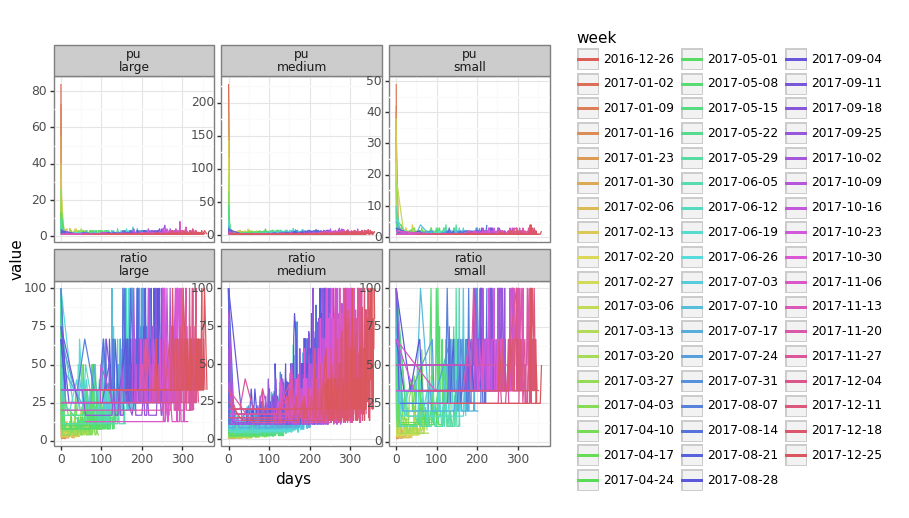

<ggplot: (8784918503677)>

In [11]:
(
    ggplot(cnt, aes('days', 'value', color = 'week')) +
    gg.geom_line() +
    gg.facet_wrap('~type + size', scales = 'free_y') +
    gg.theme_bw()
)

# iterator

In [12]:
mat = [list('ABC'), list('DEF'), list('GHI')]
[(r, c, letters) for r, rows in enumerate(mat) for c, letters in enumerate(rows)]

[(0, 0, 'A'),
 (0, 1, 'B'),
 (0, 2, 'C'),
 (1, 0, 'D'),
 (1, 1, 'E'),
 (1, 2, 'F'),
 (2, 0, 'G'),
 (2, 1, 'H'),
 (2, 2, 'I')]

In [13]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [15]:
{key : eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])') for key in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}

In [17]:
def add_arthor_with_name(name) :
  def add_arthor(func) :
    def wrapper(*args, **kwargs) :
      return name + '\n' + func(*args, **kwargs)
    return wrapper
  return add_arthor

def add_arthor(func) :
  def wrapper(*args, **kwargs) :
    return 'park' + '\n' + func(*args, **kwargs)
  return wrapper

@add_arthor_with_name('kim')
def get_title(title) :
  return title 

@add_arthor
def get_title2(t1, t2) :
  return t1 + " " + t2

In [19]:
print(get_title('도무지 난 용서가 안되'))
print(get_title2('나를 차갑게 돌아서도', '내일 부턴 볼 수 없어도'))

kim
도무지 난 용서가 안되
park
나를 차갑게 돌아서도 내일 부턴 볼 수 없어도
